In [152]:
from utilities import cwt, paper_cwt
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

### Helper functions to proccess signals

In [153]:
def bpfilter(data, dt, bp_low, bp_high):
    '''
    Butterworth filter
    '''
    sos = signal.butter(6, [bp_low, bp_high], btype='bandpass', fs=1/dt, output='sos')
    return signal.sosfiltfilt(sos, data, axis=-1)

def DAS_preprocessing(data, dt, fl, fh):
    """this is important otherwise the plot doesn't look right 

    Args:
        data (_type_): _description_
        dt (_type_): _description_
        fl (_type_): _description_
        fh (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = signal.detrend(data, axis=1)
    data = data - np.median(data, axis=0)
    data = bpfilter(data, dt, fl, fh)
    print(dt)
    return data

def plot_DAS(DAS, title=""):
    DAS = DAS_preprocessing(DAS, .02, fl=0.2, fh = 24)

    clim = DAS.std() /5e3

    seconds_shown = 600

    ax = plt.imshow(DAS, vmin=-clim, vmax=clim, extent=[0, seconds_shown,0, DAS.shape[0]], cmap='Greys', aspect='auto', origin='lower')
    plt.title(title)
    plt.xlabel("Time after Start in Seconds")
    plt.ylabel("Channel Number ")
    return ax


### Parameters

0.02


Text(0, 0.5, 'Channel Number ')

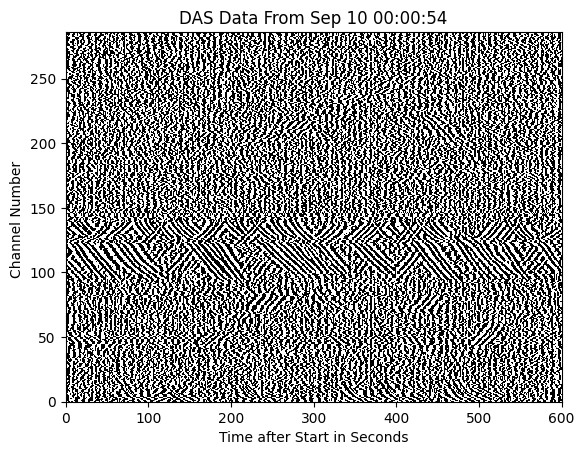

In [114]:
#Das sample with car noise from the standford paper 
september_file_path = "september10data/20160910_00:00:54.npy"
sep_data = np.load(september_file_path)

#proccess data to make display look nicer. Otherwise it's just weird black lines
proccesed_sep_data = DAS_preprocessing(sep_data, .02, fl=0.2, fh = 24)

clim = proccesed_sep_data.std() /5e3

seconds_shown = 600

plt.imshow(proccesed_sep_data, vmin=-clim, vmax=clim, extent=[0, seconds_shown,0, proccesed_sep_data.shape[0]], cmap='Greys', aspect='auto', origin='lower')
plt.title("DAS Data From Sep 10 00:00:54")
plt.xlabel("Time after Start in Seconds")
plt.ylabel("Channel Number ")

In [115]:
data_to_transform = proccesed_sep_data

dt =.02 #50 hz = 1/50 
dj = .5 #Is the largest that dj can be while still properly reconstructible 
w0 = 8 # hyperparameter from stanford paper 
n_samples = data_to_transform.shape[1]

In [252]:
scales = cwt.get_scales(dt, dj, w0, n_samples)
transform = cwt.cwt_time_vec(data_to_transform, scales, w0, dt)
transform = transform.permute(2,1,0)

In [84]:
print(scales.shape)
inverse = np.zeros(data_to_transform.shape)

for i in range(transform.shape[0]):
    inverse[i,:] = cwt.inverse_cwt(transform[i, :, :].T, scales, dj, dt, w0)


(38,)


/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_2550/2855783221.py:5: ComplexWarning: Casting complex values to real discards the imaginary part
  inverse[i,:] = cwt.inverse_cwt(transform[i, :, :].T, scales, dj, dt, w0)


0.02


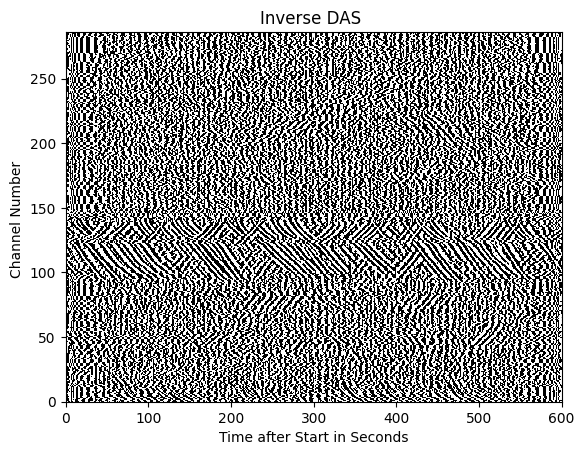

In [154]:
inverse.shape

plot_DAS(inverse, title="Inverse of DAS Data")

In [108]:
print(scales)

[3.55306333e-02 5.02479035e-02 7.10612666e-02 1.00495807e-01
 1.42122533e-01 2.00991614e-01 2.84245067e-01 4.01983228e-01
 5.68490133e-01 8.03966456e-01 1.13698027e+00 1.60793291e+00
 2.27396053e+00 3.21586582e+00 4.54792106e+00 6.43173165e+00
 9.09584213e+00 1.28634633e+01 1.81916843e+01 2.57269266e+01
 3.63833685e+01 5.14538532e+01 7.27667370e+01 1.02907706e+02
 1.45533474e+02 2.05815413e+02 2.91066948e+02 4.11630826e+02
 5.82133896e+02 8.23261651e+02 1.16426779e+03 1.64652330e+03
 2.32853558e+03 3.29304660e+03 4.65707117e+03 6.58609321e+03
 9.31414234e+03 1.31721864e+04]


In [128]:
muted_scales = np.ones(scales.shape)
muted_scales[:2] = 0.0000001
muted_scales = scales * muted_scales


muted_DAS = np.zeros(data_to_transform.shape)
for i in range(muted_DAS.shape[0]):
    muted_DAS[i,:] = cwt.inverse_cwt(transform[i, :,:].T, muted_scales, dj, dt,w0)

[3.55306333e-02 5.02479035e-02 7.10612666e-02 1.00495807e-01
 1.42122533e-01 2.00991614e-01 2.84245067e-01 4.01983228e-01
 5.68490133e-01 8.03966456e-01 1.13698027e+00 1.60793291e+00
 2.27396053e+00 3.21586582e+00 4.54792106e+00 6.43173165e+00
 9.09584213e+00 1.28634633e+01 1.81916843e+01 2.57269266e+01
 3.63833685e+01 5.14538532e+01 7.27667370e+01 1.02907706e+02
 1.45533474e+02 2.05815413e+02 2.91066948e+02 4.11630826e+02
 5.82133896e+02 8.23261651e+02 1.16426779e+03 1.64652330e+03
 2.32853558e+03 3.29304660e+03 4.65707117e+03 6.58609321e+03
 9.31414234e+03 1.31721864e+04]
[3.55306333e-09 5.02479035e-09 7.10612666e-02 1.00495807e-01
 1.42122533e-01 2.00991614e-01 2.84245067e-01 4.01983228e-01
 5.68490133e-01 8.03966456e-01 1.13698027e+00 1.60793291e+00
 2.27396053e+00 3.21586582e+00 4.54792106e+00 6.43173165e+00
 9.09584213e+00 1.28634633e+01 1.81916843e+01 2.57269266e+01
 3.63833685e+01 5.14538532e+01 7.27667370e+01 1.02907706e+02
 1.45533474e+02 2.05815413e+02 2.91066948e+02 4.11630

/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_2550/2645581812.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  muted_DAS[i,:] = cwt.inverse_cwt(transform[i, :,:].T, muted_scales, dj, dt,w0)


0.02


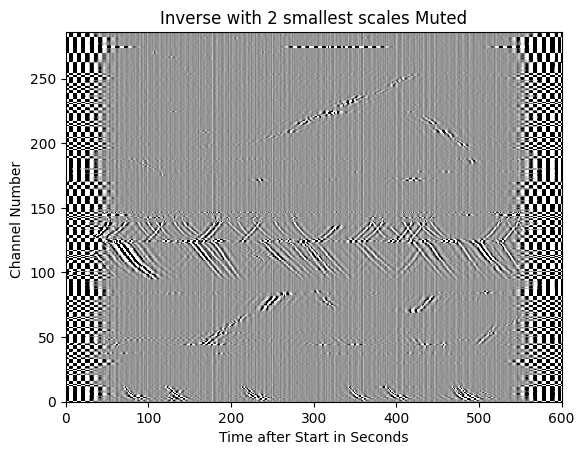

In [131]:
muted_DAS.shape

plot_DAS(muted_DAS, title='Inverse with 2 smallest scales Muted')

In [132]:
muted_scales = np.ones(scales.shape)
muted_scales[:5] = 0.0001
muted_scales = scales * muted_scales
print(scales)
print(muted_scales)


clustered_das = np.zeros(data_to_transform.shape)
for i in range(muted_DAS.shape[0]):
    if(i >= 100 and i <= 150):
        clustered_das[i,:] = cwt.inverse_cwt(transform[i, :,:].T, muted_scales, dj, dt,w0)
    else:
        clustered_das[i,:] = cwt.inverse_cwt(transform[i, :,:].T, scales, dj, dt,w0)

[3.55306333e-02 5.02479035e-02 7.10612666e-02 1.00495807e-01
 1.42122533e-01 2.00991614e-01 2.84245067e-01 4.01983228e-01
 5.68490133e-01 8.03966456e-01 1.13698027e+00 1.60793291e+00
 2.27396053e+00 3.21586582e+00 4.54792106e+00 6.43173165e+00
 9.09584213e+00 1.28634633e+01 1.81916843e+01 2.57269266e+01
 3.63833685e+01 5.14538532e+01 7.27667370e+01 1.02907706e+02
 1.45533474e+02 2.05815413e+02 2.91066948e+02 4.11630826e+02
 5.82133896e+02 8.23261651e+02 1.16426779e+03 1.64652330e+03
 2.32853558e+03 3.29304660e+03 4.65707117e+03 6.58609321e+03
 9.31414234e+03 1.31721864e+04]
[3.55306333e-06 5.02479035e-06 7.10612666e-06 1.00495807e-05
 1.42122533e-05 2.00991614e-01 2.84245067e-01 4.01983228e-01
 5.68490133e-01 8.03966456e-01 1.13698027e+00 1.60793291e+00
 2.27396053e+00 3.21586582e+00 4.54792106e+00 6.43173165e+00
 9.09584213e+00 1.28634633e+01 1.81916843e+01 2.57269266e+01
 3.63833685e+01 5.14538532e+01 7.27667370e+01 1.02907706e+02
 1.45533474e+02 2.05815413e+02 2.91066948e+02 4.11630

/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_2550/2891263347.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  clustered_das[i,:] = cwt.inverse_cwt(transform[i, :,:].T, scales, dj, dt,w0)
/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_2550/2891263347.py:11: ComplexWarning: Casting complex values to real discards the imaginary part
  clustered_das[i,:] = cwt.inverse_cwt(transform[i, :,:].T, muted_scales, dj, dt,w0)


### Examples for how clustering works

In [142]:
clustering_example = np.load('./september10data/20160910_00:00:54.npy')
print(clustering_example.shape)

(286, 15000)


0.02
(286, 15000)


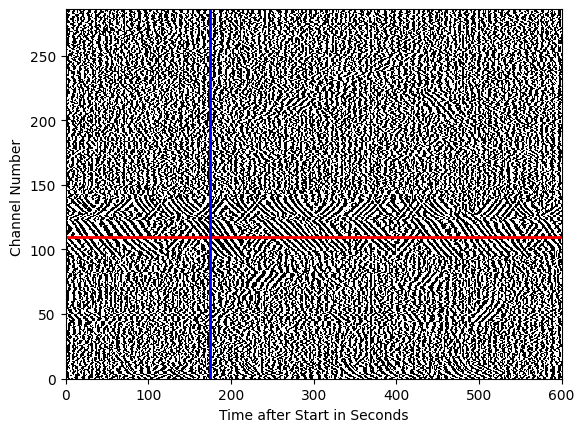

In [241]:
example_channel_number = 110
time_after_start = 175
ax = plot_DAS(clustering_example)
plt.plot([600, 0],[example_channel_number,example_channel_number], color='red', linewidth=2)
plt.plot([time_after_start, time_after_start],[0, 286], color='blue', linewidth=2 )

print(clustering_example.shape)


In [242]:
time_data = clustering_example[example_channel_number, :]
channel_data = clustering_example[:, time_after_start]

scales = cwt.get_scales(dt, dj, w0, n_samples)

time_example = cwt.cwt_time_vec(time_data[np.newaxis], scales, w0, dt)[:,:,0].real

print(time_example.shape)

torch.Size([38, 15000])


/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_2550/3476352559.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


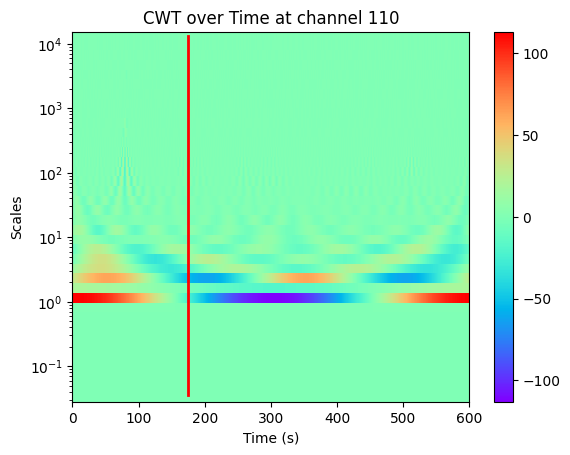

In [243]:
fig, axs = plt.subplots()
time_line = np.linspace(0, 600, n_samples)
pcm = axs.pcolormesh(time_line, scales[::-1], time_example, shading="nearest", cmap="rainbow")
axs.plot([time_after_start, time_after_start], [scales[0], scales[-1]],color='red', linewidth=2)
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_title(f'CWT over Time at channel {example_channel_number}')
axs.set_ylabel("Scales")
fig.colorbar(pcm, ax=axs)
fig.show()

In [244]:
freq_min_space= 0.04
freq_max_space= 2

space_log = space_log = np.logspace(np.log10(freq_min_space), np.log10(freq_max_space), 30)

channel_example_transform = cwt.cwt_space_vec(channel_data[np.newaxis], space_log, w0, dt)[:,0,:].real

/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_2550/1352632294.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


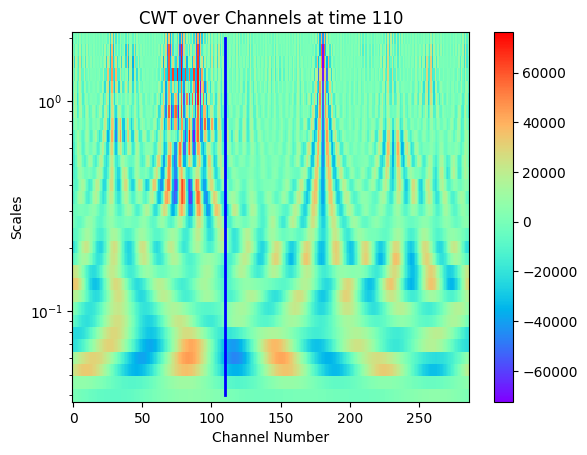

In [245]:
fig, axs = plt.subplots()
time_line = np.linspace(0, 286, 286)
pcm = axs.pcolormesh(time_line, space_log[::-1], channel_example_transform, shading="nearest", cmap="rainbow")
axs.plot([example_channel_number, example_channel_number], [space_log[0], space_log[-1]],color='blue', linewidth=2)
axs.set_yscale("log")
axs.set_xlabel("Channel Number")
axs.set_title(f'CWT over Channels at time {example_channel_number}')
axs.set_ylabel("Scales")
fig.colorbar(pcm, ax=axs)
fig.show()

/var/folders/38/7n1_2vzs5yj4rjtfy6_m6d_00000gn/T/ipykernel_2550/2655757345.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


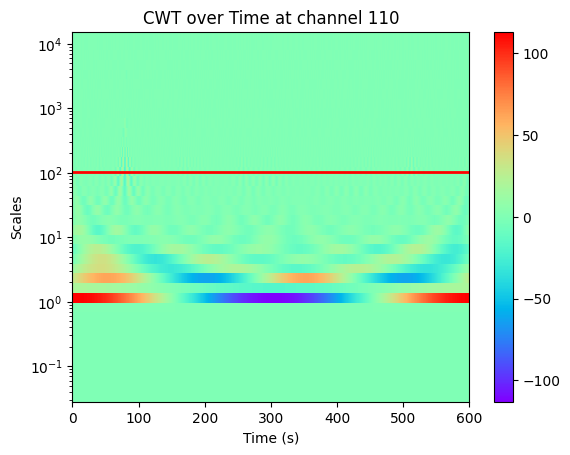

In [249]:

fig, axs = plt.subplots()
time_line = np.linspace(0, 600, n_samples)
pcm = axs.pcolormesh(time_line, scales[::-1], time_example, shading="nearest", cmap="rainbow")
axs.plot([0, 600], [scales[-15], scales[-15]],color='red', linewidth=2)
axs.set_yscale("log")
axs.set_xlabel("Time (s)")
axs.set_title(f'CWT over Time at channel {example_channel_number}')
axs.set_ylabel("Scales")
fig.colorbar(pcm, ax=axs)
fig.show()